<a href="https://colab.research.google.com/github/Deepakraj14-tamil/Leukemia-Data/blob/main/untitled21.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import seaborn as sns
import pandas as pd
from tqdm import tqdm 

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from keras.utils import to_categorical
from keras.models import Sequential 
from keras.layers import BatchNormalization, Dropout, MaxPooling2D, Dense, Conv2D, Flatten, AveragePooling2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, recall_score, precision_score, f1_score

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive') 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
path="/content/drive/MyDrive/Blood-data"
print(os.listdir(path))

['dataset-master', 'dataset2-master']


In [6]:
def loadData(folder):
    
    X = []
    y = []

    for label, subfolder in enumerate(['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']):         
        for imgFile in tqdm(os.listdir(os.path.join(folder, subfolder))):
            img_path = os.path.join(os.path.join(folder, subfolder), imgFile)
            image = cv2.imread(img_path)
            image = cv2.resize(image, [120,120])

            X.append(image/255.0)
            y.append(label)
            
    X = np.array(X, dtype = 'float32')
    y = np.array(y, dtype = 'int32')
    return X,y

In [7]:
X_train,y_train = loadData('/content/drive/MyDrive/Blood-data/dataset2-master/dataset2-master/images/TRAIN')

100%|██████████| 2499/2499 [00:57<00:00, 43.52it/s] 


In [9]:
X_test, y_test = loadData('/content/drive/MyDrive/Blood-data/dataset2-master/dataset2-master/images/TEST')

100%|██████████| 624/624 [00:08<00:00, 70.99it/s] 


In [10]:
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = 0.7)

In [11]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

In [12]:
X_train, y_train = shuffle(X_train, y_train, random_state=616)

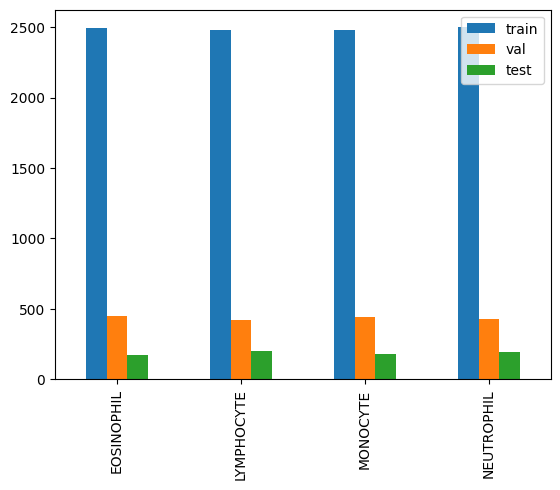

In [13]:
classNames = ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']

_, train_counts = np.unique(np.argmax(y_train,axis=1), return_counts = True)
_, val_counts = np.unique(np.argmax(y_val,axis=1), return_counts = True)
_, test_counts = np.unique(np.argmax(y_test,axis=1), return_counts = True)

pd.DataFrame({'train': train_counts, "val": val_counts, "test": test_counts}, index = classNames).plot.bar()

plt.show()

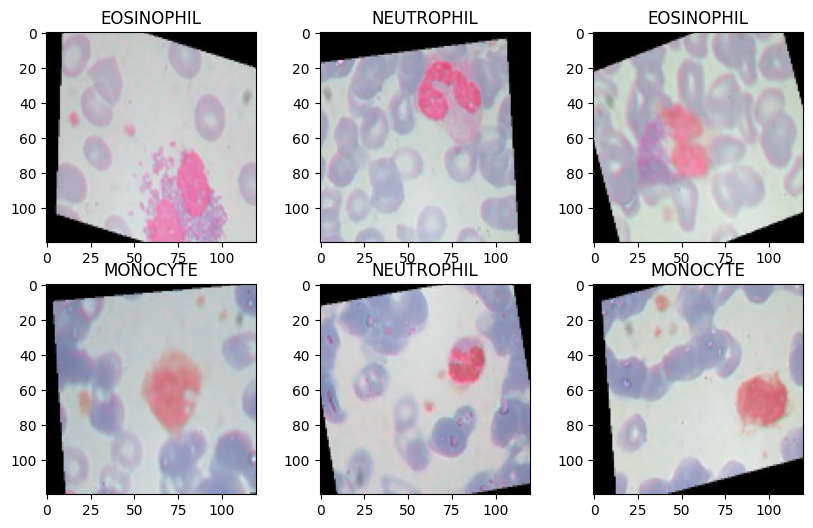

In [14]:
fig, ax = plt.subplots(2, 3, figsize=(10, 6))
for i, axi in enumerate(ax.flat):
    axi.imshow(X_train[i])
    axi.set_title(classNames[y_train[i].argmax()])
plt.show()

In [15]:
model = Sequential()

# First Conv Layer
model.add(Conv2D(16 , (3,3) , activation = 'relu' , input_shape = (120,120,3)))
model.add(Conv2D(16 , (3,3) , activation = 'relu'))
model.add(BatchNormalization())          
model.add(AveragePooling2D(pool_size = (2,2)))

# Second Conv Layer
model.add(Conv2D(32, (3,3), activation = 'relu'))
model.add(Conv2D(32, (3,3), activation = 'relu'))          
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

# Third Conv Layer
model.add(Conv2D(64, (3,3), activation = 'relu'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

#Forth Conv Layer
model.add(Conv2D(128, (3,3), activation = 'relu'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

#Fifth Conv Layer
model.add(Conv2D(256, (3,3), activation = 'relu'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

# FC layer
model.add(Flatten())
model.add(Dense(units = 256 , activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.25))

# Output layer
model.add(Dense(units = 4 , activation = 'softmax'))

# Compile
model.compile(optimizer = Adam(learning_rate=0.001) , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 118, 118, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 116, 116, 16)      2320      
                                                                 
 batch_normalization (BatchN  (None, 116, 116, 16)     64        
 ormalization)                                                   
                                                                 
 average_pooling2d (AverageP  (None, 58, 58, 16)       0         
 ooling2D)                                                       
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 32)        4640      
                                                                 
 conv2d_3 (Conv2D)           (None, 54, 54, 32)        9

In [16]:
datagen = ImageDataGenerator(
  rotation_range=20,
  width_shift_range=0.1,
  height_shift_range=0.1,
  shear_range=0.1,
  zoom_range=0.2,
  horizontal_flip=True,
  vertical_flip=True
)

In [23]:
checkpoint = ModelCheckpoint(
      filepath='model-{epoch:02d}-{val_accuracy:.2f}.h5',
      save_weights_only=True,
      monitor='val_accuracy',
      mode='max',
      save_best_only=True)
earlystop = EarlyStopping(
      monitor='val_loss', patience=3, restore_best_weights=True)
lrReduction = ReduceLROnPlateau(
    monitor = 'val_accuracy', 
    patience = 3, 
    verbose = 2, 
    factor = 0.3, 
    min_lr = 0.00001)

In [25]:
history = model.fit(datagen.flow(X_train,y_train, batch_size=32),
                 epochs=5, validation_data = [X_val, y_val],callbacks=[lrReduction ,checkpoint])

Epoch 1/5
312/312 [==============================] - 431s 1s/step - loss: 0.2088 - accuracy: 0.9190 - val_loss: 1.0533 - val_accuracy: 0.6577 - lr: 3.0000e-04
Epoch 2/5
312/312 [==============================] - 408s 1s/step - loss: 0.1866 - accuracy: 0.9295 - val_loss: 0.7305 - val_accuracy: 0.7375 - lr: 3.0000e-04
Epoch 3/5
312/312 [==============================] - 408s 1s/step - loss: 0.1787 - accuracy: 0.9303 - val_loss: 3.3852 - val_accuracy: 0.5681 - lr: 3.0000e-04
Epoch 4/5
312/312 [==============================] - 409s 1s/step - loss: 0.1817 - accuracy: 0.9316 - val_loss: 0.9600 - val_accuracy: 0.7869 - lr: 3.0000e-04
Epoch 5/5
312/312 [==============================] - 408s 1s/step - loss: 0.1669 - accuracy: 0.9376 - val_loss: 0.8153 - val_accuracy: 0.7490 - lr: 3.0000e-04


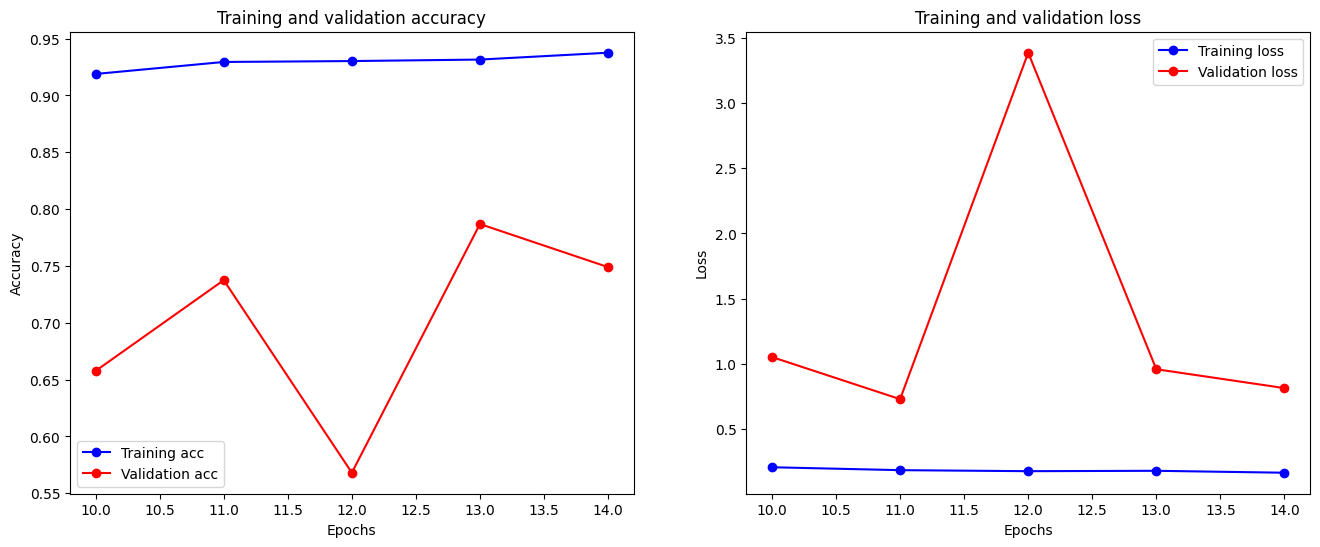

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(10, len(acc) + 10)

fig, axs = plt.subplots(1,2,figsize = (16,6))
axs[0].plot(epochs, acc, 'b-o', label='Training acc')
axs[0].plot(epochs, val_acc, 'r-o', label='Validation acc')
axs[0].set_title('Training and validation accuracy')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy')
axs[0].legend()

axs[1].plot(epochs, loss, 'b-o', label='Training loss')
axs[1].plot(epochs, val_loss, 'r-o', label='Validation loss')
axs[1].set_title('Training and validation loss')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].legend()

plt.show()

In [28]:
y_pred = model.predict(X_test)
test_result = model.evaluate(X_test, y_test)

print("Loss of the model  is - test ", test_result[0])
print("Accuracy of the model is - test", test_result[1]*100, "%")

24/24 [==============================] - 12s 513ms/step - loss: 0.8505 - accuracy: 0.7426
Loss of the model  is - test  0.8504925966262817
Accuracy of the model is - test 74.26273226737976 %


In [29]:
y_test_labels = np.argmax(y_test, axis = 1)
y_pred_labels = np.argmax(y_pred, axis = 1)

<Axes: >

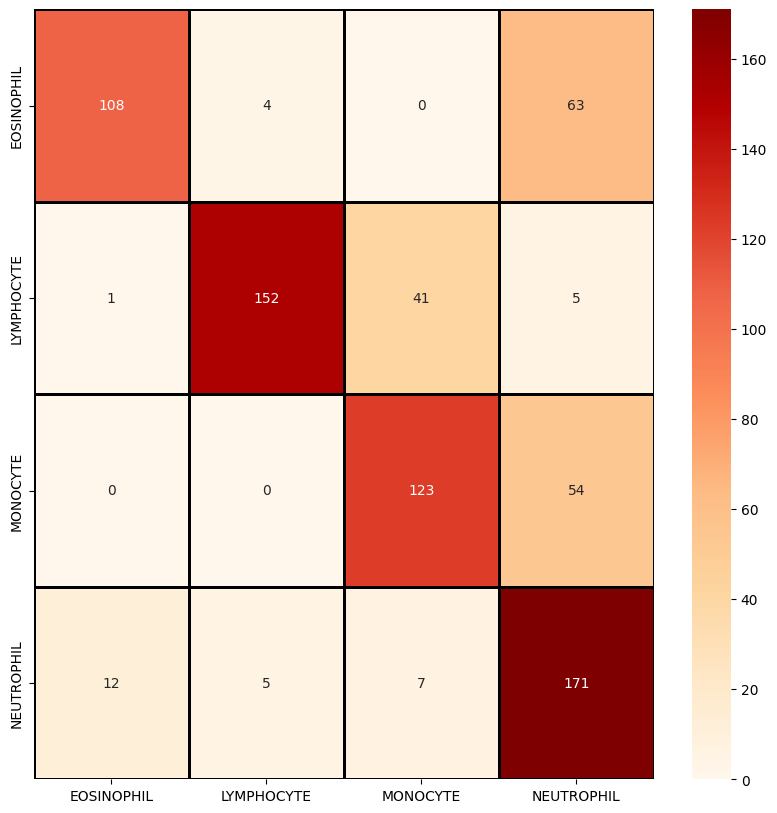

In [30]:
cm = confusion_matrix(y_test_labels, y_pred_labels)

classes = ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']

plt.figure(figsize = (10,10))
sns.heatmap(
    cm, 
    cmap = 'OrRd', 
    linecolor = 'black', 
    linewidth = 1, 
    annot = True, 
    fmt = '', 
    xticklabels = classes, 
    yticklabels = classes)

In [36]:
print("Recall of the model is - test", recall_score(y_test_class, y_pred_class, average='macro'))
print("Precision of the model is - test", precision_score(y_test_class, y_pred_class, average='macro'))
print("F1 score of the model is - test", f1_score(y_test_class, y_pred_class, average='macro'))

Recall of the model is - test 0.7382000709451523
Precision of the model is - test 0.7848943388518426
F1 score of the model is - test 0.745472599507365


In [37]:
y_pred = model.predict(X_test)

24/24 [==============================] - 5s 223ms/step


In [38]:
test_result = model.evaluate(X_test, y_test)

24/24 [==============================] - 5s 220ms/step - loss: 0.8505 - accuracy: 0.7426


In [39]:
y_pred_class = np.argmax(y_pred, axis=1)
y_test_class = np.argmax(y_test, axis=1)
print("Confusion matrix:")
print(confusion_matrix(y_test_class, y_pred_class))
print("Classification report:")
print(classification_report(y_test_class, y_pred_class))


Confusion matrix:
[[108   4   0  63]
 [  1 152  41   5]
 [  0   0 123  54]
 [ 12   5   7 171]]
Classification report:
              precision    recall  f1-score   support

           0       0.89      0.62      0.73       175
           1       0.94      0.76      0.84       199
           2       0.72      0.69      0.71       177
           3       0.58      0.88      0.70       195

    accuracy                           0.74       746
   macro avg       0.78      0.74      0.75       746
weighted avg       0.78      0.74      0.75       746



In [40]:
fpr, tpr, thresholds = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc = auc(fpr, tpr)

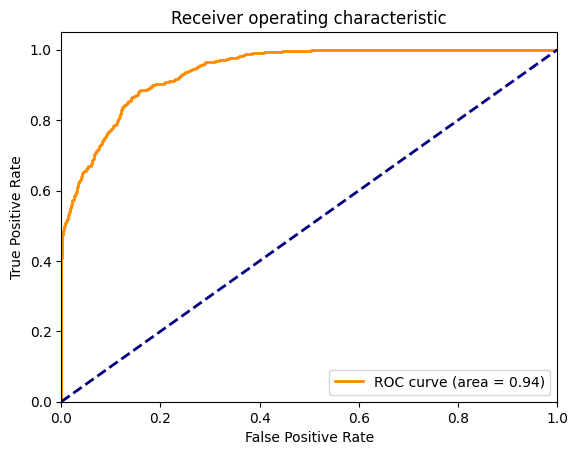

In [41]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()